In [2]:
from IPython.core.display import HTML
HTML(""" <link href="https://fonts.googleapis.com/css2?family=Inter:wght@600&family=Noto+Sans+JP&display=swap" rel="stylesheet"> 
<style>
    div.text_cell_render h1 {
        font-family: 'Inter';
        font-size: 1.7em;
        line-height:1.4em;
        text-align:center;
        }

    div.text_cell_render { 
        font-family: 'Noto Sans JP';
        font-size:1.05em;
        line-height:1.5em;
        padding-left:3em;
        padding-right:3em;
        }
</style>""")

# Analyzing the Data

The webpages associated with the input image(s) are now downloaded and enriched with metadata. Now we can start analyzing the data. In this notebook we analyze several features of the data: 
- the diachronic frequency (when was the image published)
- the top level domains (on what websites was the image found)
- the distribution of languages

# Reformatting the Data
Before we do any (text) analysis, it is useful to assemble the data and put it all in one file. Below we pull together the information found in the .json files with dates, texts and entities. We reformat the information into one .csv (comma-separated) file. CSV-files can be opened in for example Excel and Notepad and are easy to use in for example Excel or Notepad.

In [32]:
import os
import json
import re
from purl import URL
import pandas as pd
import langid
import matplotlib.pyplot as plt

In [33]:
base_path = "/media/ruben/Data Drive/react-data/test"

'''
Import the dates from the dates.txt file in the photo folder. The dates.txt file contains the URL and the associated date, separated by '||'.
We create a dictionary with the URL-date pair. This requires splitting the line on the '||' characters and excluding the URLs that have no date
associated (they are marked as 'na')
'''
dates_ref = dict()

for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
    photo_folder = os.path.join(base_path, photo)
    with open(os.path.join(photo_folder,"dates.txt"),'r') as f:
        x = f.readlines()
    dates_ref.update({d.split('|')[0]:d.split('|')[-1].replace('\n','') for d in x if d.split('|')[-1].replace('\n','') != "na" and "ERROR" not in d.split('|')[-1].replace('\n','')})

'''
Import that languages from the languages-photo.json file. 
'''
language_ref = dict()

for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
    photo_folder = os.path.join(base_path, photo)
    
    with open(os.path.join(photo_folder,'languages-'+photo+".json"),'r') as f:
        lang = json.load(f)
    
    languages = []
    
    for iterkey,items1 in lang.items():
        
        for id_, lan_items in items1.items():
            language = lan_items[0] # the language identifier also outputs the probability that the guess is right. We don't need that so we discard it here
            language_ref.update({id_:language})
                
'''
Import texts from parsed_text.json file in iteration folders. N.B.: this means that for every iteration one .json with texts is constructed.
Hence the extra loop. This loop also combines all the information in one object. In this process we also extract the so-called Top Level
Domain (TLD), for example www.facebook.com in the case of the URL www.facebook.com/user/something. 
'''
text_ref = dict()

for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
    photo_folder = os.path.join(base_path, photo)
    num_iterations = [fol for fol in os.listdir(photo_folder) if os.path.isdir(os.path.join(photo_folder,fol)) and "source" not in fol and "context" not in fol]
    num_iterations = len(num_iterations)

    start_iter = 1
    range_iter = [str(i) for i in list(range(1,num_iterations + 1))]

    folder_base = os.path.join(base_path,photo,photo)

    for iteration in range_iter:
        fn = os.path.join(folder_base + "_" +str(iteration),"txt", "parsed_text.json")
        with open(fn) as fp:
            pages = json.load(fp)
            
        for identifier,sentences in pages.items():
            
            sentences = [s.replace("\n","").lower() for s in sentences]
            sentences = [re.sub(' +', ' ', s) for s in sentences]

            url = identifier.split('html_')[-1]
            id_ = identifier.split('/html/')[1].split('.html_')[0]
            if url in dates_ref.keys():
                date = dates_ref[url]
            else:
                date = "na"
            
            text_ref.update({identifier:dict()})
            text_ref[identifier].update({"photo":photo,"url":url,"identifier":id_,"date":date,"language":language_ref[url],"topleveldomain":URL.from_string(url).domain(),"sentences":"||".join(sentences)})

In [35]:
'''
Here we transform the constructed dictionary is a DataFrame that can be exported to a .csv file. To be sure that there are no duplicate pages in our dataset
we remove the duplicates.
'''

df = pd.DataFrame.from_dict(text_ref,orient='index').reset_index()
df = df.drop_duplicates('url',keep='first')
df.columns = ["path","photo","url","identifier","date","language","topleveldomain","sentences"]
#df.to_csv('path/to/datafolder/data-full.csv',index=False)
data = df

# 1. Diachronic Frequency

One of the first things to inspect is the distribution of the webpages over the years. When were most pages published? Can we identify peaks, or gaps? With the data stored in a .csv we can relatively easily generate visualizations that provide an insight into the data. Below we first aggregate the number of webpages per year and plot it.

In [36]:
#data = pd.read_csv('path/to/datafolder/data-full.csv')

subset = data[['photo','date']] # get the photo and date columns
subset['count'] = 1 # add a count column, because every row is one observation

# loop over the dates and if the dates is not "na" extract the year
subset['year'] = ''

for c,i in enumerate(subset['date']):
    
    if "na" not in str(i):
        year = str(i)[0:4]
        subset['year'][c] = year
    else:
        subset['year'][c] = "na"
        
# Remove all observations with "na"
subset = subset[~subset['year'].isin(["na","nan"])]

# Group by photo and year and add the values
subset = subset.groupby(['photo','year']).sum().reset_index()


/home/ruben/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/ruben/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ruben/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

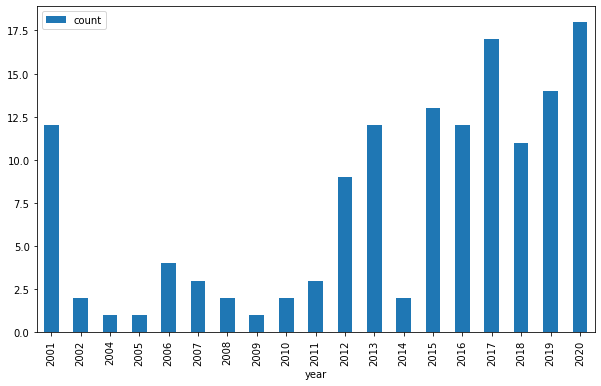

In [41]:
'''
Now we have a dataframe that has three columns: the name of the photo, the year and the webpage frequency. Now it is possible to plot the data.
If you used only one photo you can simply plot the years against the frequency:
'''
p = subset.plot.bar(x='year',y='count',figsize=(10,6))
plt.show()

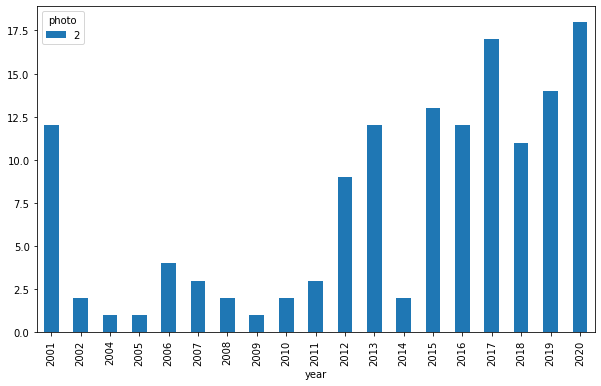

In [42]:
'''
If you have multiple photos, mutate the dataframe in such a way that it has the following column structure:

year | photo_name_1 | photo_name_2
1999 | 4            | 55

This operation also works if you have one photo, so you can safely run this cell
'''

subset = subset.pivot(index='year',columns='photo',values='count').reset_index()
p = subset.plot.bar(x='year',y=list(subset.columns)[1:],figsize=(10,6))
plt.show()

# 2. Top Level Domains

The URLs that refer to the pages were the image is found are highly specific. They consist of several compontents: 
- the "http" component that indicates the use of the Hypertext Transfer Protocol, a set of rules for web traffic
- the "www" component that indicates that the page is on the World Wide Web
- the "top level domain" ("facebook", "bbc", "twitter") the name of the website
- a domain extension (".nl",".com") 
- a "path" that refers to specific data or pages on the website 

Especially the top level domains (TLDs) and the extensions can help in identifying frequently occuring websites. To extract the TLDS we use an existing URL-parser, a Python module that identifies the parts of the URL.

To extract the TLDs we use something called "list comprehension". This is a very effective way of doing things with lists. Imagine the following list: ```[1,2,3,4,5]```, stored in the variable ```list1```. The list elements can be shown by doing ```[item for item in list1]```. Once we know this, we could also do ```[item + 1 for item in list1]```, which results in ```[2,3,4,5,6]```. In fact, we could do anything in this way. Below we use the ```URL.from_string(x).domain()``` function to extract the TLDs.

Next, we use a very handy module called ```Counter()``` to get the most frequent TLDs.

In [50]:
from collections import Counter

tlds = [URL.from_string(u).domain() for u in list(set(data['url']))]
Counter(tlds).most_common(15)

[('wikivisually.com', 6),
 ('twitter.com', 6),
 ('genius.com', 5),
 ('www.pinterest.com', 4),
 ('scalar.usc.edu', 4),
 ('www.liberties.eu', 4),
 ('www.revolvy.com', 4),
 ('m.dagospia.com', 4),
 ('gramho.com', 4),
 ('omonoianews.com', 3),
 ('www.tapatalk.com', 3),
 ('www.liberoquotidiano.it', 3),
 ('www.picuki.com', 2),
 ('bellerofonte.blogspot.com', 2),
 ('indicator.gr', 2)]

# 3. Languages

We already know something of the languages by looking at the extensions. A better way to look at the distribution of languages is identifying the language of the webpage text itself. Luckily, several Python modules are able to identify the language of a text. In the previous notebook, we used ```langid.classify()``` to identify languages. Since it is very fast, we repeat this here. Because the classifier also outputs the probability of a correct guess (which is always very high because we have lots of textual data) we have to select the first element from its output (```identifier.classify('example webpage text')[0]```)

In [61]:
from langid.langid import LanguageIdentifier, model
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)

data['language'] = [identifier.classify(x)[0] for x in list(data['sentences'])]

In [62]:
'''
Now we use Counter() to find the language distribution
'''

Counter(list(data['language'])).most_common(15)

[('en', 57),
 ('it', 53),
 ('tr', 9),
 ('el', 8),
 ('es', 8),
 ('nl', 6),
 ('fr', 4),
 ('pt', 3),
 ('eo', 3),
 ('da', 1),
 ('ru', 1),
 ('bs', 1),
 ('de', 1),
 ('cs', 1),
 ('hu', 1)]

# Text Analysis

So far we have worked with the metadata. The contents of the webpages are also a valuable source of information. This is where we move into the area of text analysis. In this notebook we will work on the basic unit of text analysis: word counts.

Before we can count words, we need to again reformat the data. This involves several steps:
- removing the '||' separators we used in the parsing
- splitting the web page text into tokens. Tokens are "an instance of a sequence of characters in some particular document that are grouped together as a useful semantic unit for processing" ([Stanford NLP](https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html)). This often translates into words, but a "." or a "&" is also identified as a token. For the tokenization of the data we use the powerful ```nltk``` (Natural Language Toolkit).

Also, we cannot really compare words in multiple languages, so we first subset a dataset with a language of your choice (in the example it is italian, marked as 'it')

In [68]:
import nltk

In [74]:
texts_subset = data[data['language']=='it']['sentences']
texts_subset = [t.replace('||','') for t in texts_subset]
texts_subset = [nltk.word_tokenize(t) for t in texts_subset]

# Merge all the webpages into one 'Bag of Words' using a more complex form of list comprehension (that 'flattens' a list of lists)
subset_bow = [word for webpage in texts_subset for word in webpage]

# find the most frequent words
Counter(subset_bow).most_common(15)

[(',', 2645),
 ('di', 1337),
 ('e', 825),
 ('che', 743),
 ('la', 618),
 ('in', 612),
 ('il', 592),
 ('’', 564),
 ('a', 557),
 ('un', 555),
 ('per', 504),
 ('non', 444),
 ('è', 414),
 ('del', 394),
 ('una', 324)]

The words shown above do not come as a surprise. Words like 'the' and 'a' occur numerous times and do not tell us anything about the semantic content of the webpages. One way to come closer to the contents of the pages is to remove frequently occuring 'stopwords'. This can also be done with ```nltk```.

In [80]:
from nltk.corpus import stopwords
subset_bow_nostops = [word for word in subset_bow if word not in stopwords.words('italian') and len(word) > 2]

In [81]:
Counter(subset_bow_nostops).most_common(15)

[('stato', 119),
 ('giuliani', 113),
 ('carlo', 110),
 ('anni', 86),
 ('fatto', 82),
 ('due', 70),
 ('genova', 67),
 ('vita', 64),
 ('solo', 59),
 ('parte', 53),
 ('ancora', 52),
 ('fare', 50),
 ('dopo', 50),
 ('poi', 49),
 ('ordine', 49)]

The words that appear in the list after removing the stopwords are already more indicative of the contents of the webpage. Word frequencies are the building blocks of many other methods. Two of them are particularly useful and will be introduced in the remainder of this notebook.

One useful measure is "Term Frequency Inverted Document Frequency" (TFIDF). This can be used to find words that are relevant in a particular document. 